# Fit NSF to all the successful simulations on a specific morph

In [443]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [444]:
import sys
sys.path.append('../')

import pandas as pd
import torch
import numpy as np

from parameter_setup import load_ground_truth_params, load_prior_max, load_prior_min
from sbi.inference import SNPE, prepare_for_sbi
from sbi.utils import BoxUniform, pairplot, posterior_nn
from support import PriorRejectionProposal
from sbi.analysis import conditional_pairplot

from helpers import *
from sbi.analysis import eval_conditional_density

In [217]:
data1 = pd.read_pickle(
    "../../../arco_sims/all_simulations_from_GA/selected_BAC_1.pickle"
)

In [268]:
data2 = pd.read_pickle(
    "../../../arco_sims/all_simulations_from_GA/selected_BAC_2.pickle"
)

In [269]:
data3 = pd.read_pickle(
    "../../../arco_sims/all_simulations_from_GA/selected_BAC_3.pickle"
)

In [270]:
full_data = pd.concat([data1, data2, data3])

In [271]:
data1 = 0.0
data2 = 0.0
data3 = 0.0

In [272]:
morphs = full_data["morphology"].drop_duplicates()

In [421]:
newdf = select_some_morphologies(full_data, morphs.values[0])
dataframe_with_some_morphs = drop_columns(newdf)
newdf = 0.0

In [422]:
theta = dataframe_with_some_morphs.to_numpy()
np.random.shuffle(theta)
print(theta.shape)

(1504090, 35)


In [446]:
names_ = load_short_names()

### Define hyperparameters for inference

In [423]:
num_datapoints = 500000
num_hiddens = 100
num_transforms = 5
training_batch_size = 2_000
max_num_epochs = 100
stop_after_epochs = 10
num_bins = 20

### Define ingredients for SNPE

In [424]:
prior = BoxUniform(torch.as_tensor(load_prior_min()), torch.as_tensor(load_prior_max()))

In [425]:
net_builder = posterior_nn(
    "nsf",
    z_score_theta=True,
    z_score_x=False,
    hidden_features=num_hiddens,
    num_transforms=num_transforms,
)

In [426]:
theta_train = torch.as_tensor(theta[:num_datapoints], dtype=torch.float32)
x = torch.ones(theta_train.shape[0], 5)
print("Number of training points: ", theta_train.shape[0])

Number of training points:  500000


### Plot gt samples

/home/michael/Documents/sbi/sbi/utils/plot.py:180: UserWarning: Importing `pairplot` from `sbi.utils` is deprecated since sbi v0.15.0. Instead, use `from sbi.analysis import pairplot`.
  warn(


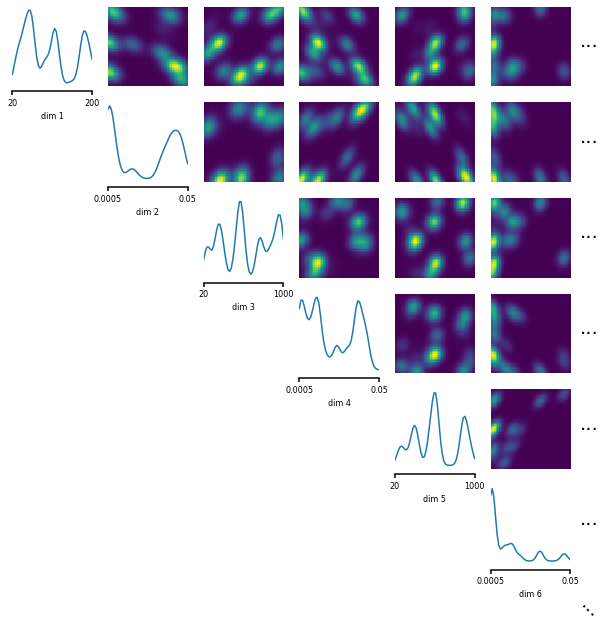

In [297]:
limits = np.asarray([load_prior_min(), load_prior_max()])
_ = pairplot(theta_train[:10000], subset=[0,1,2,3,4,5], limits=limits.T, ticks=limits.T, upper='kde', diag='kde')

### Set up SNPE

In [302]:
inference = SNPE(prior, density_estimator=net_builder)

In [303]:
inference = inference.append_simulations(theta_train, x, proposal=None)

In [304]:
_ = torch.manual_seed(0)
density_estimator = inference.train(
    training_batch_size=2_000,
    max_num_epochs=max_num_epochs,
    stop_after_epochs=stop_after_epochs,
)

In [305]:
posterior = inference.build_posterior().set_default_x(torch.ones(1, 5))

In [306]:
# import pickle
# with open("density_morphWR71_Cell6_L5TT_constant_mean.pkl", "wb") as handle:
#     pickle.dump(posterior, handle)

In [430]:
import pickle
with open("density_morphWR71_Cell6_L5TT_constant_mean.pkl", "rb") as handle:
    posterior = pickle.load(handle)

In [390]:
_ = torch.manual_seed(0)
samples = posterior.sample((10_000,))

/home/michael/Documents/sbi/sbi/utils/plot.py:180: UserWarning: Importing `pairplot` from `sbi.utils` is deprecated since sbi v0.15.0. Instead, use `from sbi.analysis import pairplot`.
  warn(


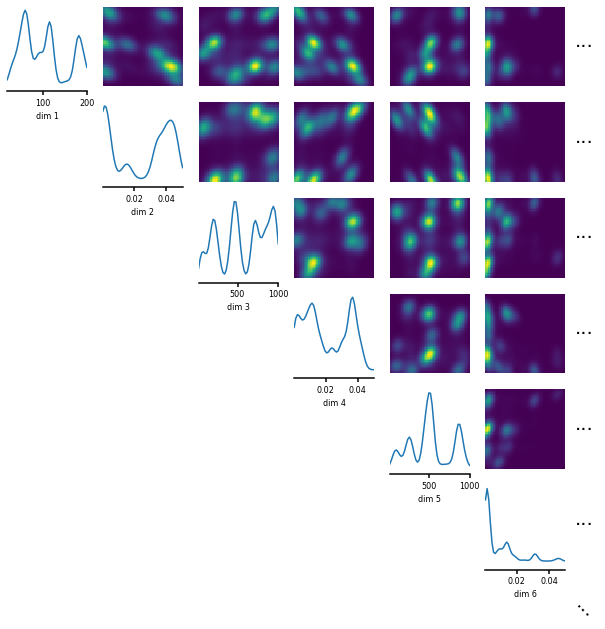

In [309]:
limits = np.asarray([load_prior_min(), load_prior_max()])
_ = pairplot(samples, subset=[0, 1, 2, 3, 4, 5], limits=limits.T, upper='kde', diag='kde')

### Obtaining the support

In [431]:
support = PriorRejectionProposal(posterior, prior, log_prob_offset=0.0, quantile=0.0, device="cpu")

/home/michael/Documents/lfi-experiments/bursting_biophysics/GA_SNPE_notebooks/support.py:28: UserWarning: You are using `cpu` to sample from the `PriorRejectionProposal`. This will be much slower than sampling with `cuda`.
  warn(


In [432]:
limits = np.asarray([load_prior_min(), load_prior_max()]).T

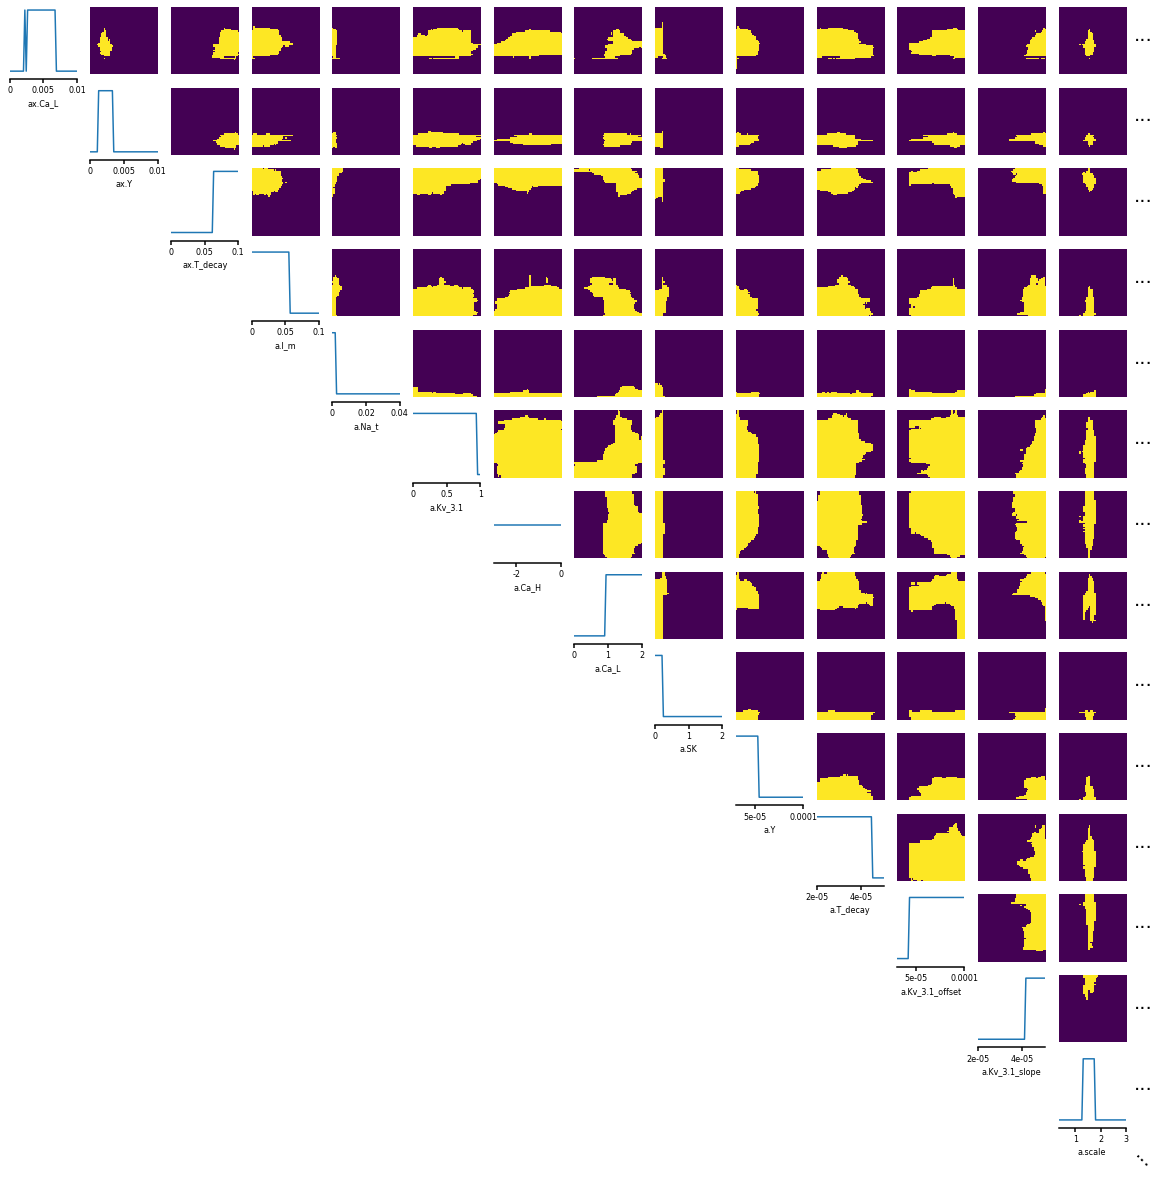

In [437]:
_ = torch.manual_seed(0)
condition = posterior.sample((1,))
_ = conditional_pairplot(support, condition=condition, limits=limits, subset=[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34], figsize=(20, 20), labels=names_)

In [412]:
def plot_1d_marginal():
    fig, ax = plt.subplots(1, 35, figsize=(30, 1))
    resolution = 100
    fraction = 1.0
    for i in range(35):
        vec, _ = np.histogram(theta[:, i], range=limits[i], bins=resolution)
        vec = vec > 0.0
        ax[i].plot(np.linspace(limits[i, 0], limits[i, 1], resolution), vec)
        ax[i].set_ylim([-0.02, 1])
        ax[i].set_yticks([])
        ax[i].set_xlabel(names_[i])
        fraction *= (np.sum(vec) / resolution)
    ax[17].set_title(f"Fraction of filled space:  {fraction}", fontsize=12.)
    plt.savefig("morph85_marginal.png", dpi=200, bbox_inches="tight", facecolor="w")
    plt.show()

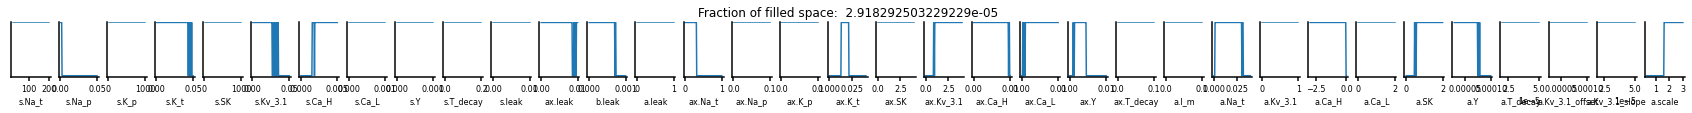

In [413]:
plot_1d_marginal()

In [414]:
def plot_1d_cond():
    fig, ax = plt.subplots(1, 35, figsize=(30, 1))
    condition = posterior.sample((1, ))
    resolution=100
    fraction = 1.0
    for i in range(35):
        vec = eval_conditional_density(
            support,
            condition,
            limits=limits,
            dim1=i,
            dim2=i,
            resolution=resolution,
            return_raw_log_prob=True
        )
        ax[i].plot(np.linspace(limits[i, 0], limits[i, 1], resolution), vec)
        ax[i].set_ylim([-0.02, 1])
        ax[i].set_yticks([])
        ax[i].set_xlabel(names_[i])
        fraction *= (torch.sum(vec) / resolution)
    ax[17].set_title(f"Fraction of filled space:  {fraction.item()}", fontsize=12.)
    plt.savefig("morph85_conditional.png", dpi=200, bbox_inches="tight", facecolor="w")
    plt.show()

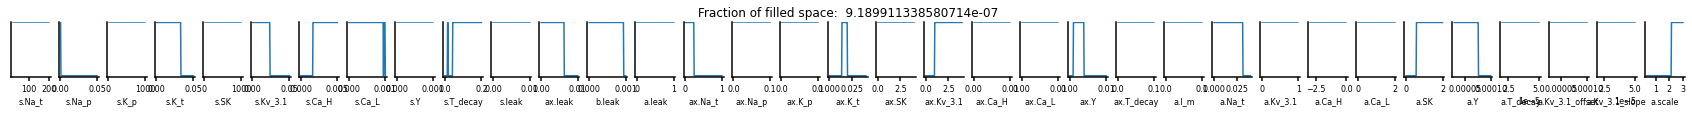

In [415]:
plot_1d_cond()

In [400]:
conditions = posterior.sample((10, ))
resolution=100
all_fractions = []
for c in conditions:
    total_frac = 1.0
    for i in range(35):
        vec = eval_conditional_density(
            support,
            c,
            limits=limits,
            dim1=i,
            dim2=i,
            resolution=resolution,
            return_raw_log_prob=True
        )
        frac = torch.sum(vec) / resolution
        total_frac *= frac
    print("total_frac", total_frac)
    all_fractions.append(total_frac)


total_frac tensor(1.4408e-06)
total_frac tensor(6.5844e-10)
total_frac tensor(4.7520e-09)
total_frac tensor(5.3540e-07)
total_frac tensor(1.4009e-06)
total_frac tensor(5.5130e-08)
total_frac tensor(2.2730e-09)
total_frac tensor(8.7967e-12)
total_frac tensor(2.6229e-06)
total_frac tensor(1.1787e-22)


In [275]:
fractions = []
for m in morphs.values:
    newdf = select_some_morphologies(full_data, m)
    dataframe_with_some_morphs = drop_columns(newdf)
    current_theta = dataframe_with_some_morphs.to_numpy()
    fractions.append(compute_fraction(current_theta))

In [276]:
fractions

[0.023855088411,
 3.726879360915424e-05,
 1.0358516354621166e-08,
 2.918292503229229e-05,
 7.091534162078552e-13,
 0.03402812448,
 6.799009563476063e-08,
 2.3389383067767354e-14,
 0.0005610631453610602,
 7.731465502028026e-15,
 4.1465233080489886e-17,
 2.344969823714795e-10,
 7.802365880543364e-06,
 0.00028747777538553314,
 1.6384000000000008e-66,
 0.0002852714086148584,
 0.0017996710516175827]

In [281]:
# compute_fraction_of_conditional:
newdf = select_some_morphologies(full_data, morphs.values[0])
dataframe_with_some_morphs = drop_columns(newdf)
current_theta = dataframe_with_some_morphs.to_numpy()

In [283]:
current_theta.shape

(1504090, 35)